In [1]:
import os
os.chdir('/home/dfy/MedCLIP')
import torch

from medclip import MedCLIPModel, MedCLIPVisionModelViT
from medclip import MedCLIPProcessor
from medclip import PromptClassifier

In [2]:
# init models

processor = MedCLIPProcessor()
model = MedCLIPModel(vision_cls=MedCLIPVisionModelViT)
model.from_pretrained("./pretrained/medclip-vit")
clf = PromptClassifier(model, ensemble=True)
clf.cuda()

/home/dfy/miniconda3/envs/medclip/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at emi

load model weight from: ./pretrained/medclip-vit


PromptClassifier(
  (model): MedCLIPModel(
    (vision_model): MedCLIPVisionModelViT(
      (model): SwinModel(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value): Linear(in_features=96, out_features=9

In [3]:
def pad_img(img, min_size=224, fill_color=0):
    '''pad img to square.
    '''
    x, y = img.size
    size = max(min_size, x, y)
    new_im = Image.new('L', (size, size), fill_color)
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [4]:
# prepare input image
from PIL import Image
img = Image.open('./example_data/view1_frontal.jpg')
img = pad_img(img)
inputs = processor(images=img, return_tensors="pt")
# prepare input prompt texts
from medclip.prompts import generate_chexpert_class_prompts, process_class_prompts

cls_prompts = process_class_prompts(generate_chexpert_class_prompts(n=10))
inputs['prompt_inputs'] = cls_prompts

sample 10 num of prompts for Atelectasis from total 210
sample 10 num of prompts for Cardiomegaly from total 15
sample 10 num of prompts for Consolidation from total 192
sample 10 num of prompts for Edema from total 18
sample 10 num of prompts for Pleural Effusion from total 54


In [5]:
# 分类结果
output = clf(**inputs)
print(output)

{'logits': tensor([[0.3603, 0.4752, 0.1665, 0.2265, 0.3831]], device='cuda:0',
       grad_fn=<StackBackward0>), 'class_names': ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']}


In [6]:
model.vision_model.model.encoder.layers[-1].blocks[-1]

SwinLayer(
  (layernorm_before): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attention): SwinAttention(
    (self): SwinSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (output): SwinSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (drop_path): SwinDropPath(p=0.1)
  (layernorm_after): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (intermediate): SwinIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): SwinOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [7]:
# explainability
from explainability.explainable_medclip import ExplainableMedCLIP
vision_target_layer = model.vision_model.model.encoder.layers[-1].blocks[-1].layernorm_before
explainer = ExplainableMedCLIP(model,vision_target_layer=vision_target_layer,enable_text_attention=False)
# 可选用不同class的prompt：['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
explain_out = explainer(input_ids=inputs['prompt_inputs']['Atelectasis']['input_ids'],
                pixel_values=inputs['pixel_values'],
                attention_mask=inputs['prompt_inputs']['Atelectasis']['token_type_ids']
           )

In [12]:

cam = explainer.vit_gradcam(
    pixel_values=inputs['pixel_values'],
    input_ids=inputs['prompt_inputs']['Atelectasis']['input_ids'],
    attention_mask=inputs['prompt_inputs']['Atelectasis']['token_type_ids'],
    prompt_index=0
)
heatmap = explainer.cam_to_heatmap(cam)

logits: tensor([[0.5526, 0.4843, 0.4945, 0.5596, 0.5869, 0.7416, 0.4996, 0.5516, 0.5191,
         0.6321]], device='cuda:0', grad_fn=<TBackward0>)
tensor(4.2363e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.2363e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.2363e-05, device='cuda:0', grad_fn=<MaxBackward1>)


0.0 1.0
(390, 390)
0.0 1.0
(390, 390, 3)


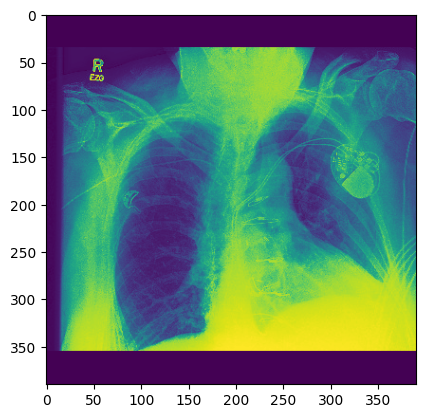

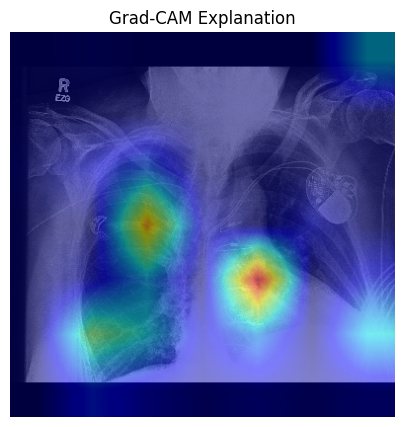

In [11]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
img = np.array(img).astype(np.float32)/255.0
plt.imshow(img)
print(img.min(), img.max())
def apply_colormap(heatmap):
    """
    heatmap: (H, W), values in [0,1]
    return: (H, W, 3)
    """
    heatmap = heatmap.detach().cpu().numpy()
    colored = cm.jet(heatmap)[:, :, :3]  # drop alpha
    return colored

def overlay_heatmap(image, heatmap, alpha=0.4):
    """
    image: np.ndarray (H,W) or (H,W,3) in [0,1]
    heatmap: np.ndarray (H,W,3) in [0,1]
    """

    # 1. 灰度图 → RGB
    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1)
    print(image.min(), image.max())
    print(image.shape)
    # 2. resize heatmap 到 image 尺寸（如果需要）
    if image.shape[:2] != heatmap.shape[:2]:
        heatmap_pil = Image.fromarray((heatmap * 255).astype(np.uint8))
        heatmap_pil = heatmap_pil.resize(
            (image.shape[1], image.shape[0]),
            Image.BILINEAR
        )
        heatmap = np.array(heatmap_pil) / 255.0

    # 3. 叠加
    overlay = image * (1 - alpha) + heatmap * alpha
    # overlay = image
    return overlay.clip(0, 1)

color_heatmap = apply_colormap(heatmap[0])
print(img.shape)
overlay = overlay_heatmap(img, color_heatmap, alpha=0.5)
plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Explanation")
plt.show()
